Start Date: 11/10/2024
End Date: 17/10/2024
Author: Fabio Barile

Let's import the libraries we'll use in the project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize

Now, we are going to download datasets of 5 cryptocurrencies: 
BTC, ETH, BNB, DOGE, USDT
We'll keep only two columns for each dataset: 'time' and 'ReferenceRateUSD'. In order to align all the datas to the same date we are going to consider 7 years. 

In [4]:
df_btc_unrefined = pd.read_csv('btc.csv').convert_dtypes()
df_eth_unrefined = pd.read_csv('eth.csv').convert_dtypes()
df_bnb_unrefined = pd.read_csv('bnb.csv').convert_dtypes()
df_doge_unrefined = pd.read_csv('doge.csv').convert_dtypes()
df_usdt_unrefined = pd.read_csv('usdt.csv').convert_dtypes()

def df_filtering(df, columns_to_keep):

    """"
    This function converts column 'time' to datetime and filters datasets keeping the right columns
    and considering days after 2017-10-09 and before 2024-10-11 (missing value)

    Parameters:
    df (pd.DataFrame): The DataFrame containing unrefined datas.
    columns_to_keep (list of strings: the columns we decide to consider for the analysis
    
    Returns:
    pd.DataFrame: DataFrame with a new 'daily_returns' column

    """

    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
    df_new = df[columns_to_keep]
    df_new = df_new[(df_new['time'] >= '2017-10-9') & (df_new['time'] < '2024-10-11')]
    return df_new

df_btc = df_filtering(df_btc_unrefined, ['time', 'ReferenceRateUSD'])
df_eth = df_filtering(df_eth_unrefined, ['time', 'ReferenceRateUSD'])
df_bnb = df_filtering(df_bnb_unrefined, ['time', 'ReferenceRateUSD'])
df_doge = df_filtering(df_doge_unrefined, ['time', 'ReferenceRateUSD'])
df_usdt = df_filtering(df_usdt_unrefined, ['time', 'ReferenceRateUSD'])


# Checking for NaN values in filtered dataframes
dataframes = [df_btc, df_eth, df_bnb, df_usdt, df_doge]

def NaN_counting(df):
    return df.isna().sum()

for i in dataframes:
    print(NaN_counting(i['ReferenceRateUSD']))


C:\Users\fabar\AppData\Local\Temp\ipykernel_3272\3544364977.py:1: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_btc_unrefined = pd.read_csv('btc.csv').convert_dtypes()


0
0
0
0
0


In this section we'll calculate daily_returns and add this column to the refined dataset.

In [5]:
def calculate_daily_returns(df, pricecolumn = 'ReferenceRateUSD'):
    """
    Calculate daily returns and append as a new column to the DataFrame.
    Drop rows with NaN in daily returns
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing price data.
    price_column (str): The column containing price data (default is 'ReferenceRateUSD').
    
    Returns:
    pd.DataFrame: DataFrame with a new 'daily_returns' column.
    
    """

    df['daily_returns'] = df[pricecolumn].pct_change()
    df = df.dropna(subset=['daily_returns']) # we'll drop the date 2017-10-9 
    return df

df_btc = calculate_daily_returns(df_btc)
df_eth = calculate_daily_returns(df_eth)
df_bnb = calculate_daily_returns(df_bnb)
df_doge = calculate_daily_returns(df_doge)
df_usdt = calculate_daily_returns(df_usdt)

Now, we start to analyze the distribution of daily returns.

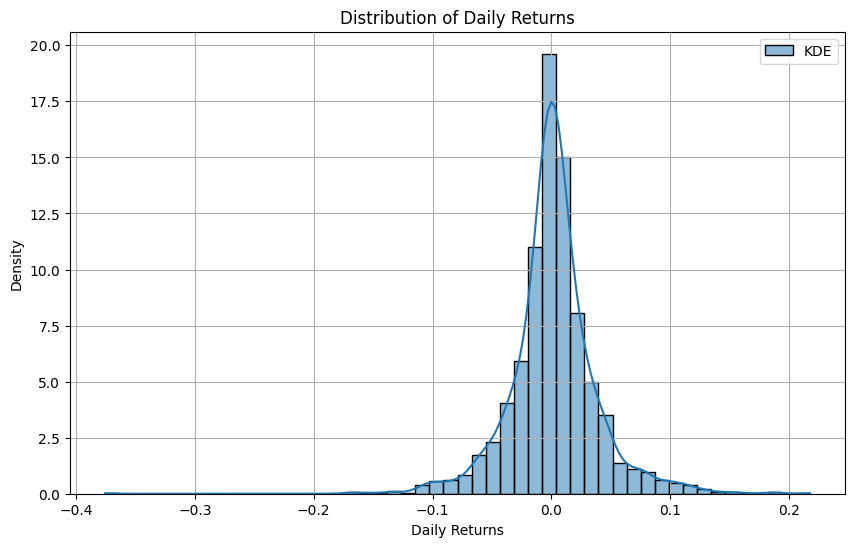

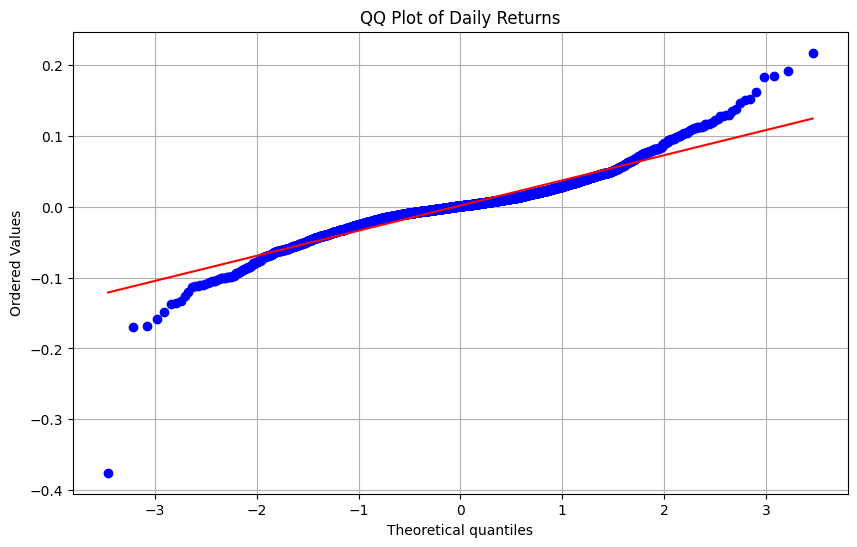

Kurtosis: 7.3804


In [16]:
def analyze_normality(df, column = 'daily_returns'):
    """
    The function analyzes the distribution of daily returns for a given cryptocurrency DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing daily returns.
    column (str): The column containing data to analyze (default is 'daily_returns').
    
    Returns:
    float: The kurtosis of the daily returns.
    """
    # Plotting the histogram and KDE
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=50, kde=True, stat='density', label='KDE')
    plt.title('Distribution of Daily Returns')
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

    # QQ Plot
    plt.figure(figsize=(10, 6))
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title('QQ Plot of Daily Returns')
    plt.grid()
    plt.show()

    # Calculate kurtosis
    kurtosis = df[column].kurtosis()
    print(f'Kurtosis: {kurtosis:.4f}')

    return kurtosis


# Example (BTC)
kurtosis_btcprice = analyze_normality(df_btc)

Kurtosis is a statistical measure that describes the shape of a probability distribution's tails in relation to its overall shape. Specifically, it assesses whether the data are heavy-tailed or light-tailed compared to a normal distribution.
The normal distribution has a kurtosis of 3
A high kurtosis can signal that an asset may behave unpredictably because it implies a higher probability of extreme price movements. 

In the next section we'll calculate monthly and annual volatility

In [7]:
def calculate_volatility(df, period = 'ME'):
    """
    Calculate volatility on a monthly or annual basis.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing daily returns.
    period (str): The period over which to calculate volatility ('ME' for monthly, 'YE' for yearly).
    
    Returns:
    pd.Series: A series containing the volatility for each month or year.
    """
    
    # Group by month ('ME') or year ('YE') and calculate the standard deviation of daily returns

    if period == 'ME':
        # Filter the data to exclude partial month (October 2017 and October 2024)
        df = df[(df['time'] >= '2017-11-01') & (df['time']< '2024-10-01')]
        # Calculate monthly volatility
        monthly_volatility = df.resample('ME', on='time')['daily_returns'].std()
        monthly_volatility.name = 'Monthly Volatility'
        return monthly_volatility
    
    elif period == 'YE':
        # Filter the data to exclude partial years (2017 and 2024)
        df = df[(df['time'] >= '2018-01-01') & (df['time'] <= '2023-12-31')]
        # Calculate annual volatility
        annual_volatility = df.resample('YE', on='time')['daily_returns'].std() * np.sqrt(252)
        annual_volatility.name = 'Annual Volatility'
        return annual_volatility
    
    else:
        raise ValueError("Period must be 'ME' for monthly or 'YE' for yearly")

# Example usage for monthly and annual volatility
btc_monthly_vol = calculate_volatility(df_btc, period='ME')
btc_annual_vol = calculate_volatility(df_btc, period='YE')

print(btc_monthly_vol.head())
print(btc_monthly_vol.tail())
print(btc_annual_vol)



time
2017-11-30    0.047525
2017-12-31    0.078082
2018-01-31    0.065064
2018-02-28    0.072159
2018-03-31    0.045351
Freq: ME, Name: Monthly Volatility, dtype: Float64
time
2024-05-31    0.030064
2024-06-30    0.016195
2024-07-31      0.0236
2024-08-31    0.035996
2024-09-30    0.021445
Freq: ME, Name: Monthly Volatility, dtype: Float64
time
2018-12-31    0.691749
2019-12-31    0.588665
2020-12-31    0.611996
2021-12-31    0.654559
2022-12-31    0.529957
2023-12-31     0.36337
Freq: YE-DEC, Name: Annual Volatility, dtype: Float64


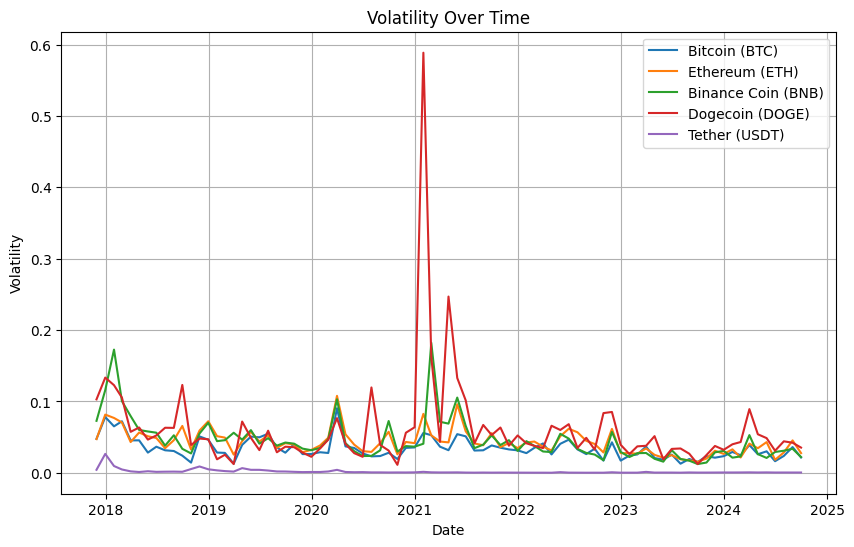

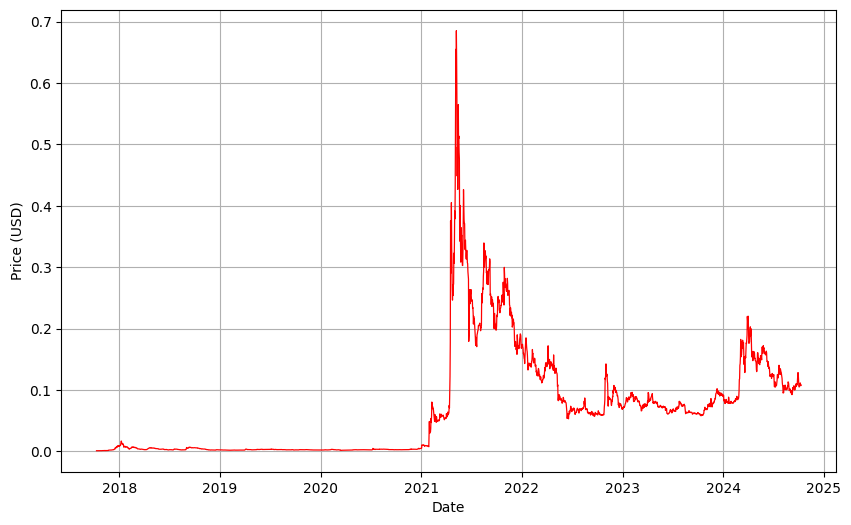

In [14]:
def plot_volatility(df_list, crypto_names):
    """
    Plot the volatility of multiple cryptocurrencies over time.

    Parameters:
    df_list (list of pd.Series): List of Series containing the volatility for each cryptocurrency.
    crypto_names (list of str): List of names for labeling the cryptocurrencies.
    """

    plt.figure(figsize=(10, 6))

    for df, name in zip(df_list, crypto_names):
        plt.plot(df.index, df, label=name)

    plt.title('Volatility Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()

    return 

btc_vol = calculate_volatility(df_btc, period='ME')
eth_vol = calculate_volatility(df_eth, period='ME')
bnb_vol = calculate_volatility(df_bnb, period='ME')
usdt_vol = calculate_volatility(df_usdt, period='ME')
doge_vol = calculate_volatility(df_doge, period='ME')

# Plotting volatility
plot_volatility([btc_vol, eth_vol, bnb_vol, doge_vol, usdt_vol], ['Bitcoin (BTC)', 'Ethereum (ETH)', 'Binance Coin (BNB)', 'Dogecoin (DOGE)', 'Tether (USDT)'])

# Plotting DOGE price over time
plt.figure(figsize=(10, 6))
plt.plot(df_doge['time'], df_doge['ReferenceRateUSD'], color = 'red', label = 'DOGE', linewidth = 0.9)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.show()



Elon Musk began tweeting about the meme-coin DOGE in early 2021. His tweets often included memes, jokes and positive comments about DOGE, which helped to capture the attention of the cryptocurrency community and the general public. Tweets attracted fueled interest and speculation around Dogecoin, contributing to its price volatility.

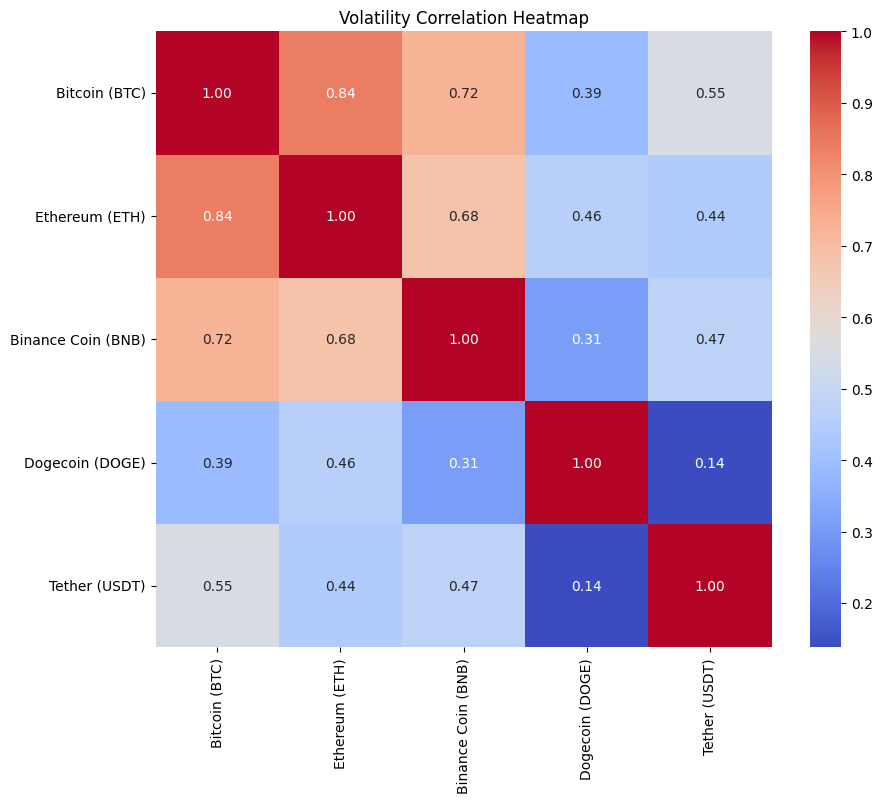

In [17]:
def plot_volatility_correlation(df_list, crypto_names):
    """
    The function plots a heatmap of the correlation between the volatilities of different cryptocurrencies.

    Parameters:
    df_list (list of pd.Series): List of Series containing the volatility for each cryptocurrency.
    crypto_names (list of str): List of names for labeling the cryptocurrencies.
    """
    vol_df = pd.concat(df_list, axis=1) # adding columns
    vol_df.columns = crypto_names
    
    correlation_matrix = vol_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Volatility Correlation Heatmap')
    plt.show()

plot_volatility_correlation([btc_vol, eth_vol, bnb_vol, doge_vol, usdt_vol],['Bitcoin (BTC)', 'Ethereum (ETH)', 'Binance Coin (BNB)', 'Dogecoin (DOGE)', 'Tether (USDT)'])


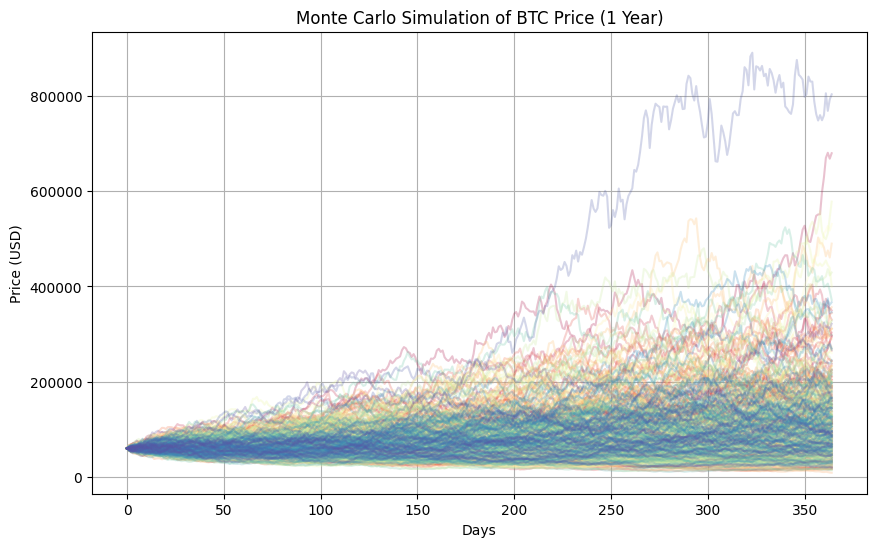

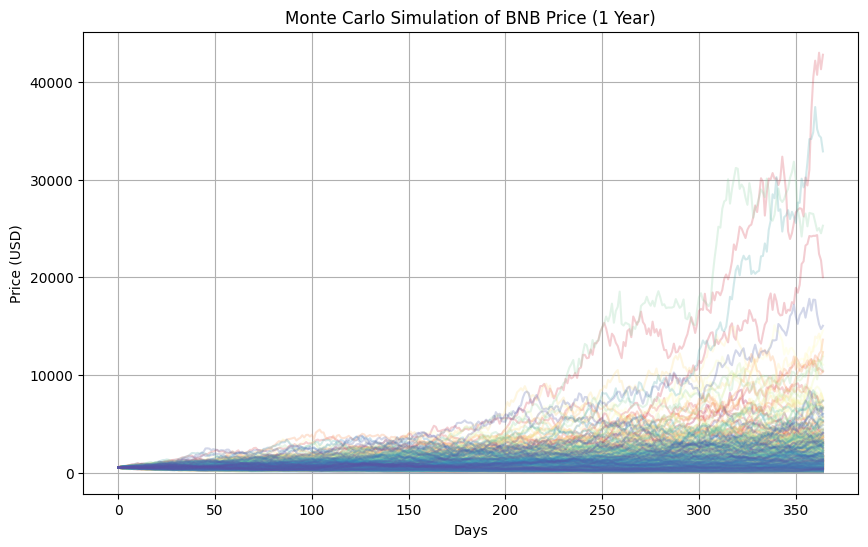

In [40]:
def montecarlo_singlestock(df, num_simulations, days, name):
    """
    Simulates the future price of a cryptocurrency using Monte Carlo simulation

    Parameters:
    df (pd.DataFrame): DataFrame containing daily_returns for the crypto.
    num_simulations (int): Number of simulations to run.
    days (int): Number of days to simulate into the future.
    name (str): Name of the crypto for plot title
    Returns:
    np.ndarray: Simulated price paths

    """

    # Calculate mean and volatility from daily returns
    mu = df['daily_returns'].mean()
    volatility = df['daily_returns'].std()

    # Initial price
    Seed = df['ReferenceRateUSD'].iloc[-1] #Last avaiable price
    
    price_paths = np.zeros((num_simulations, days))
    price_paths[:, 0] = Seed

    
    for t in range(1, days):
        # Generate random returns
        random_returns = np.random.normal(mu, volatility, num_simulations)
        # Calculate the price at time t
        price_paths[:, t] = price_paths[:, t-1]*(1+random_returns)

    # Generate a colormap
    colors = plt.cm.Spectral(np.linspace(0, 1, num_simulations))

    # Plot the simulated paths
    plt.figure(figsize=(10, 6))
    for i in range(num_simulations):
        plt.plot(price_paths[i, :], color=colors[i], alpha=0.25)  # Apply different colors
    plt.title(f'Monte Carlo Simulation of {name} Price (1 Year)')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.grid()
    plt.show()

    return

# Examples
montecarlo_singlestock(df_btc, 500, 365, name='BTC')
montecarlo_singlestock(df_bnb, 500, 365, name='BNB')



The goal of the next section is to create an optimized cryptocurrencies portfolio.
The main criteria upon which we will base our research is the Sharpe Ratio.

In [44]:
# Let's create a dataframe containing daily_returns of each crypto and its label
# Extract daily returns using tolist() and combine them into a 2D array
returns_array = np.array([
    df_btc['daily_returns'].tolist(),
    df_eth['daily_returns'].tolist(),        
    df_bnb['daily_returns'].tolist(),
    df_doge['daily_returns'].tolist(),
    df_usdt['daily_returns'].tolist()
]).T  
# Cryptocurrency labels
labels = ['BTC', 'ETH', 'BNB', 'DOGE', 'USDT']

df_returns = pd.DataFrame(returns_array, columns=labels)
print(df_returns.head())


        BTC       ETH       BNB      DOGE      USDT
0  0.038427 -0.040935  0.109105 -0.071175  0.000678
1 -0.007631  0.005523 -0.001195  0.014884 -0.001645
2  0.015585  0.014209  0.025181  0.054984  0.001727
3  0.120188  0.002268 -0.058197  0.019226 -0.002091
4  0.040864  0.110321  0.068209 -0.013613  0.000363


In [47]:
# Logaritmic returns provide a better representation of the performance of an investment.
# They provide a more symmetric distribution of returns and can mitigate the effect of outliers.
# Logaritmic returns are particularly useful in cases where the prices of assest vary significantly,
# such as Bitcoin (which is priced in the thousands of dollars) versus Tether (which is priced around
# 1 dollar)

df_returns_log = df_returns.apply(lambda x: np.log(1+x))
cov_matrix = (df_returns_log.cov())*252
print(cov_matrix)

def standard_deviation(weights, matrix):
    variance = weights.T @ matrix @ weights
    return np.sqrt(variance)


def expected_return(weights, dfReturns):
    return np.sum(dfReturns.mean()*weights)*252


           BTC       ETH       BNB      DOGE      USDT
BTC   0.348674  0.346404  0.322379  0.342256  0.003796
ETH   0.346404  0.551783  0.404186  0.413223  0.005430
BNB   0.322379  0.404186  0.692899  0.379284  0.000831
DOGE  0.342256  0.413223  0.379284  1.244219  0.001650
USDT  0.003796  0.005430  0.000831  0.001650  0.003331


[0.         0.         0.5        0.10188311 0.39811689]


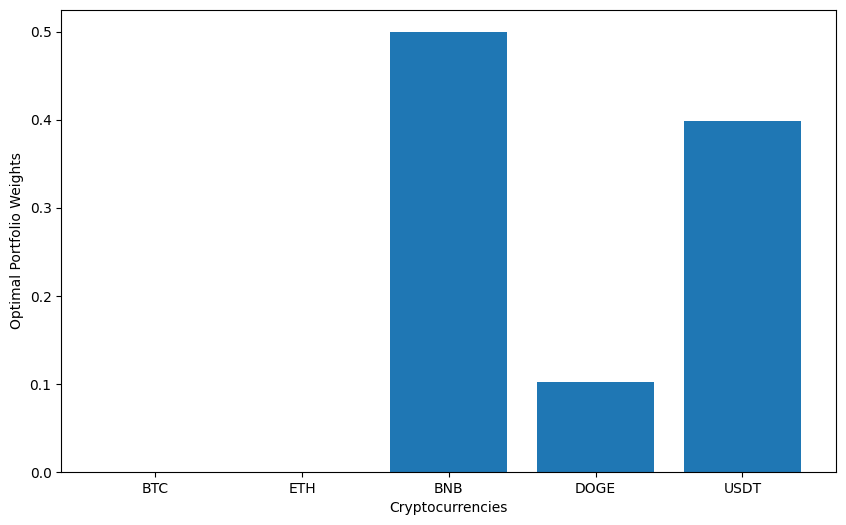

In [56]:
# We can consider a risk free ratio of 2%.
risk_free_rate = 0.02

def sharpe_ratio(weights, dfReturns, cov_matrix, risk_free_rate=0.02):
    return (expected_return(weights, dfReturns)-risk_free_rate)/ standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, dfReturns, matrix, risk_free_rate):
        return -sharpe_ratio(weights, dfReturns, matrix, risk_free_rate)

# Dictionary that specifies constraints for the optimization function
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(5)]
initial_weights = [0.2, 0.2, 0.2, 0.2, 0.2] #initial guess


optimized_results = minimize(neg_sharpe_ratio, initial_weights, 
                            args=(df_returns_log, cov_matrix, risk_free_rate), 
                            method='SLSQP', 
                            constraints=constraints,
                            bounds=bounds)

optimized_weights = optimized_results.x
print(optimized_weights)

plt.figure(figsize=(10, 6))
plt.bar(labels, optimized_weights)
plt.xlabel('Cryptocurrencies')
plt.ylabel('Optimal Portfolio Weights')
plt.show()

The results might seem unusual at first glance, especially with such a high allocation to BNB and USDT, but there are key factors to consider:

BNB has historically shown strong growth and volatility. The optimization model may have assigned a high weight because BNB likely has a favorable risk-return ratio based on the historical data.

USDT is a stablecoin, so its volatility is very low, and its price is pegged to the US dollar. While it offers minimal returns, it acts as a stabilizing asset in the portfolio. The model might be using USDT to reduce overall risk and dampen the volatility. The high allocation to USDT indicates that the model is prioritizing risk management and sees USDT as a way to reduce the portfolio’s overall volatility

DOGE has been highly volatile in recent years, often influenced by external factors like social media. The 10.18% allocation suggests the model sees some return potential in DOGE but is cautious about over-allocating due to its higher risk.

BTC and ETH tend to be highly correlated with other cryptocurrencies, particularly BNB. If the model perceives that BNB offers a better risk/return trade-off compared to BTC or ETH, it might exclude them to avoid redundancy. Essentially, the model could consider that BNB provides similar returns but with a more favorable volatility profile.

It's very likely that, considering also years before 2017, the model could favor BTC and ETH over the other cryptocurrencies.

Now, we'll predict the evolution of a portfolio with optimized weights through a Monte Carlo Simulation.
Initial Portfolio Value: $ 1000

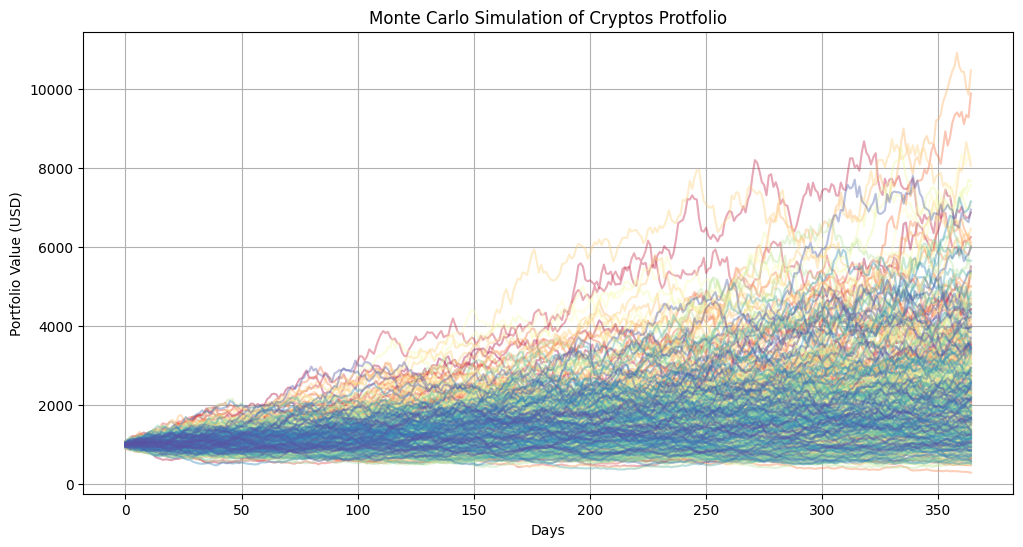

In [82]:
num_simulations=500
days=365
initial_value = 1000
mean_returns = df_returns.mean()
CovMatrix = df_returns.cov()

# Prepare array to hold portfolio values for each simulation
portfolio_simulations = np.zeros((num_simulations, days))
portfolio_simulations[:, 0] = initial_value

for i in range(1, num_simulations):
    daily_returns = np.random.multivariate_normal(mean_returns, CovMatrix, size=days)
    portfolio_simulations[i, :] = initial_value * (1 + np.dot(daily_returns, optimized_weights)).cumprod()


# Plotting the results
colors = plt.cm.Spectral(np.linspace(0, 1, num_simulations))

plt.figure(figsize=(12, 6))
for i in range(1,num_simulations):
    plt.plot(portfolio_simulations[i, :], color=colors[i], alpha=0.4)  # Apply different colors
plt.title('Monte Carlo Simulation of Cryptos Protfolio')
plt.xlabel('Days')   
plt.ylabel('Portfolio Value (USD)')
plt.grid()
plt.show()
